### **Connect Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Load Dataset**

In [ ]:
from google.colab import files
files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"hayammostafa","key":"896f16eefec0014e243ed2341e2947fa"}'}

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d adityajn105/flickr8k
!unzip flickr8k.zip -d flickr8k

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'
unzip:  cannot find or open flickr8k.zip, flickr8k.zip.zip or flickr8k.zip.ZIP.


### **Imports**

In [ ]:
import os
import re
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, Layer
from tensorflow.keras import layers

### **Preprocessing**

In [ ]:
BASE_DIR = '/content/drive/MyDrive/flickr8k'
WORKING_DIR = '/content'

In [ ]:
def clean(mapping):
    for key, captions in mapping.items(): #key=image
        for i in range(len(captions)):

            caption = captions[i].lower()

            caption = re.sub(r'[^a-zA-Z]', ' ', caption)

            caption = re.sub(r'\s+', ' ', caption)

            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'

            captions[i] = caption


In [ ]:
with open('/content/drive/MyDrive/captions.txt', 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:
print(captions_doc[:500])

1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg,A bl


In [ ]:
# create mapping of image to captions
mapping = {}

for line in tqdm(captions_doc.split('\n')):

    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]

    image_id = image_id.split('.')[0]

    caption = " ".join(caption)

    if image_id not in mapping:
        mapping[image_id] = []

    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
clean(mapping)
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

len(all_captions)

40455

In [ ]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

### **Tokenization**

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
print(vocab_size)

8427


In [ ]:
with open('/content/drive/MyDrive/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [ ]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

### **Feature Extract**

In [ ]:
model = VGG16() #load model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
features = {}

directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):

    img_path = os.path.join(directory, img_name)

    image = load_img(img_path, target_size=(224, 224))

    image = img_to_array(image)

    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    image = preprocess_input(image)

    feature = model.predict(image, verbose=0)

    image_id = img_name.split('.')[0]

    features[image_id] = feature

### **Load and Store Features**

In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join('/content/drive/MyDrive/features.pkl'), 'wb'))

NameError: name 'features' is not defined

In [ ]:
# load features from pickle
with open(os.path.join(WORKING_DIR, '/content/drive/MyDrive/features.pkl'), 'rb') as f:
    features = pickle.load(f)

### **Split Train and Test**

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

### **Data** **Generator**

In [ ]:
def data_generator(image_ids, captions_mapping, image_features_dict, tokenizer, max_length, vocab_size, batch_size):
    while True:
        image_features, input_captions, target_words = [], [], []
        count = 0

        for image_id in image_ids:
            if image_id not in image_features_dict:
                print(f"Image {image_id} has no data, skipping it and continuing.")
                continue

            captions = captions_mapping[image_id]

            for caption in captions:
                caption_sequence = tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(caption_sequence)):
                    partial_caption = caption_sequence[:i]
                    next_word = caption_sequence[i]

                    partial_caption = pad_sequences([partial_caption], maxlen=max_length, padding='post')[0]
                    next_word = to_categorical(next_word, num_classes=vocab_size)

                    image_features.append(image_features_dict[image_id][0])
                    input_captions.append(partial_caption)
                    target_words.append(next_word)

            count += 1

            if count == batch_size:

                yield {"image_input": np.array(image_features), "text_input": np.array(input_captions)}, np.array(target_words)
                image_features, input_captions, target_words = [], [], []
                count = 0

### **Model Creation**

In [ ]:
class Attention(Layer):
    def __init__(self, attention_dim, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.attention_dim = attention_dim

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], self.attention_dim),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.attention_dim,),
                                 initializer='zeros',
                                 trainable=True)
        self.u = self.add_weight(shape=(self.attention_dim, 1),
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, inputs):
        u_it = K.tanh(K.dot(inputs, self.W) + self.b)       # shape: (batch_size, time_steps, attention_dim)
        a_it = K.softmax(K.dot(u_it, self.u), axis=1)       # shape: (batch_size, time_steps, 1)
        output = inputs * a_it                              # shape: (batch_size, time_steps, features)
        return K.sum(output, axis=1)                        # shape: (batch_size, features)

In [ ]:
# Image feature layers
from tensorflow.keras.layers import BatchNormalization

inputs1 = Input(shape=(4096,), name="image_input")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
fe2 = BatchNormalization()(fe2)


# Sequence feature layers (Text inputs)
inputs2 = Input(shape=(max_length,), name="text_input")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256, return_sequences=True)(se2)

# Attention Layer
attention = Attention(attention_dim=256)(se3)

# Decoder part (Combining Image and Attention-based LSTM features)
decoder1 = add([fe2, attention])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Model definition
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


NameError: Exception encountered when calling Attention.call().

[1mCould not automatically infer the output shape / dtype of 'attention_1' (of type Attention). Either the `Attention.call()` method is incorrect, or you need to implement the `Attention.compute_output_spec() / compute_output_shape()` method. Error encountered:

name 'K' is not defined[0m

Arguments received by Attention.call():
  • args=('<KerasTensor shape=(None, 35, 256), dtype=float32, sparse=False, name=keras_tensor_36>',)
  • kwargs=<class 'inspect._empty'>

### **Train Model**

In [ ]:
epochs = 90
batch_size = 64
steps_per_epoch = len(train) // batch_size
val_steps = len(test) // batch_size

train_generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
val_generator = data_generator(test, mapping, features, tokenizer, max_length, vocab_size, batch_size)

model.fit(train_generator,
          epochs=epochs,
          steps_per_epoch=steps_per_epoch,
          validation_data=val_generator,
          validation_steps=val_steps,
          verbose=1)

In [ ]:
model.save('/content/drive/MyDrive/train_model_90.keras')

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/train_model_90.keras', custom_objects={'Attention': Attention})

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'attention' (of type Attention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
          return word
    return None

In [ ]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'

    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        yhat = model.predict([image.reshape(1, 4096), sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break

    final_caption = in_text.split()[1:-1]
    return ' '.join(final_caption)

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual captions
    captions = mapping[key]
    actual_captions = [caption.split() for caption in captions]

    # predict caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    y_pred = y_pred.split()

    actual.append(actual_captions)
    predicted.append(y_pred)

print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.379769
BLEU-2: 0.217427
BLEU-3: 0.127036
BLEU-4: 0.072619


## **Test Random**

In [ ]:
import random
from PIL import Image
import matplotlib.pyplot as plt

def test_random_image(model, features, tokenizer, max_length, image_dir):
    image_ids = list(features.keys())
    image_id = random.choice(image_ids)

    image_path = os.path.join(image_dir, image_id + '.jpg')
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')

    image_feature = features[image_id]
    caption = predict_caption(model, image_feature, tokenizer, max_length)
    print( caption)

image_directory = os.path.join(BASE_DIR, '/content/drive/MyDrive/Images')
test_random_image(model, features, tokenizer, max_length, image_directory)

dog swims through the water


## **Test Upload**

Saving 112243673_fd68255217.jpg to 112243673_fd68255217.jpg


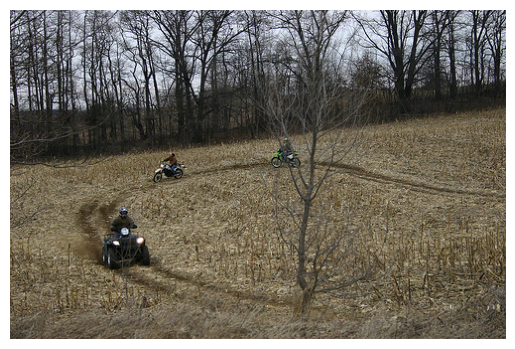

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_621']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


Generated Caption: three people are riding on atv in field


In [ ]:
def test_external_image(model, features, tokenizer, max_length):
    uploaded = files.upload()

    image_filename = next(iter(uploaded))

    image = Image.open(image_filename)

    plt.imshow(image)
    plt.axis('off')
    plt.show()

    vgg_model = VGG16()
    vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

    # Preprocess the image
    image = load_img(image_filename, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)

    # Extract features using VGG16
    image_feature = vgg_model.predict(image, verbose=0)

    caption = predict_caption(model, image_feature, tokenizer, max_length)

    print("Generated Caption:", caption)

test_external_image(model, features, tokenizer, max_length)